**NTUST course: Computer Vision and Applications (CI5336701, 2022 Spring)**

**Midterm Project: Measure and compare your foot-prints by taking pictures**

# 讀取來源圖檔集

In [1]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/drive')
MidTerm_Image_Ori_Path_Left = '/content/drive/MyDrive/Course/11002/Computer Vision/MidTerm/Left.jpg'
MidTerm_Image_Ori_Path_Right = '/content/drive/MyDrive/Course/11002/Computer Vision/MidTerm/Right.jpg'
MidTerm_Image_Result_Path = "/content/drive/MyDrive/Course/11002/Computer Vision/MidTerm/Merge.jpg"
Ori_Imgae_Left = cv2.imread(MidTerm_Image_Ori_Path_Left)
Ori_Imgae_Left = cv2.resize(Ori_Imgae_Left, (1024, 1024), interpolation=cv2.INTER_AREA)
Ori_Imgae_Right = cv2.imread(MidTerm_Image_Ori_Path_Right)
Ori_Imgae_Right = cv2.resize(Ori_Imgae_Right, (1024, 1024), interpolation=cv2.INTER_AREA)
#cv2_imshow(Ori_Imgae_Left)

Mounted at /content/drive


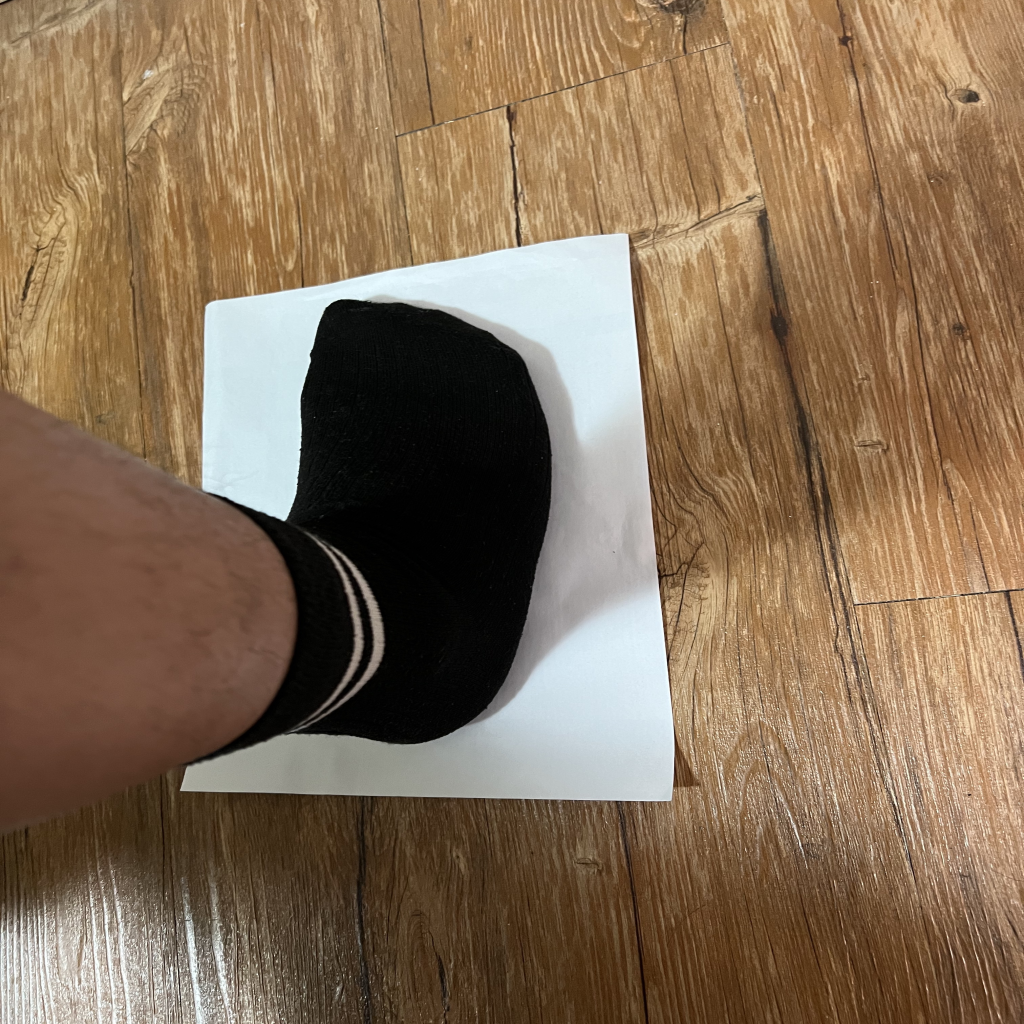

In [ ]:
cv2_imshow(Ori_Imgae_Right)

# 確認左右轉換圖片座標位置

In [ ]:
#Left_Position = np.asarray([[116,11],[802,131],[938,857],[71,961]])
Left_Position = np.asarray([[240,211],[102,870],[736,877],[750,305]])
#Right_Position = np.asarray([[72,90],[790,40],[992,873],[23,920]])
Right_Position = np.asarray([[200,300],[175,787],[670,793],[622,227]])
Correction_Position = np.asarray([[0,0],[1024,0],[1024,1024],[0,1024]])

# 裁減圖片工作, 透過透過OpenCV FillPoly 轉換

In [ ]:
def Crop_Image_Point(Src_Imgae_Ori, Point):
    # 透過點位座標裁減出預計"轉換影像", 以及遮罩
    Mask = np.zeros(Src_Imgae_Ori.shape, dtype=np.uint8)
    cv2.fillPoly(Mask, [Point.astype(np.int32)], (255,)*Src_Imgae_Ori.shape[2])
    return cv2.bitwise_and(Src_Imgae_Ori, Mask), Mask

In [ ]:
# 裁減原始圖片
Left_Image , L_mask = Crop_Image_Point(Ori_Imgae_Left, Left_Position)
Right_Image, R_mask = Crop_Image_Point(Ori_Imgae_Right, Right_Position)
Correction_Image, C_mask = Crop_Image_Point(Ori_Imgae_Left, Correction_Position)

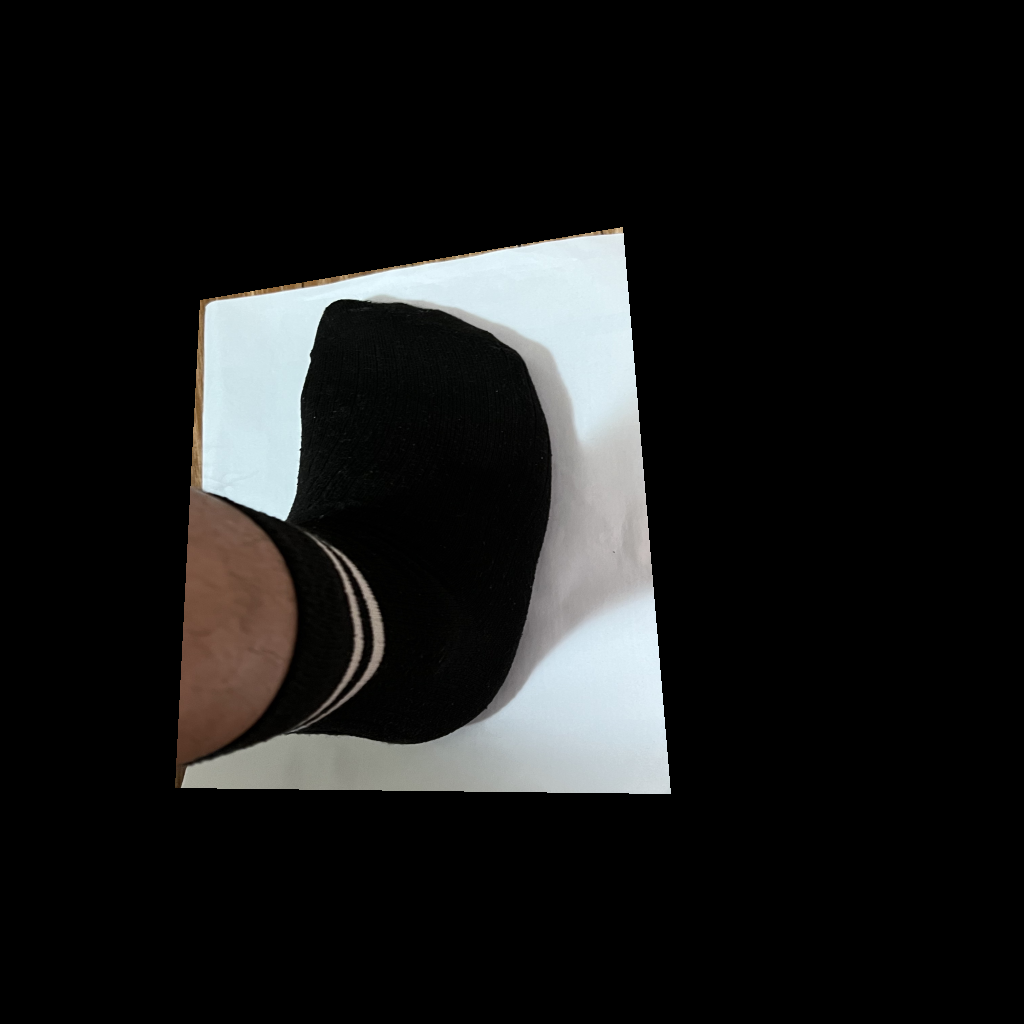

In [ ]:
cv2_imshow(Right_Image)

# 計算 Homography 公式, 採用OpenCV findHomography 

In [ ]:
def CalCv2Homography(x, xp):
    #透過 OpenCV 計算 Homography 矩陣數值
    #x' = H * X
    HomoMatrix, _ = cv2.findHomography(x, xp)
    return HomoMatrix

In [ ]:
HomoPara_Left = CalCv2Homography(Left_Position, Right_Position)
HomoPara_Right = CalCv2Homography(Right_Position, Right_Position)

# 透過 Homography Matrix 進行轉換

In [ ]:
def Convert_Image(Original_Image_Left, Original_Image_Right, Left_Image, Right_Image, HomoMatrix_Left, HomoMatrix_Right):
    #Original_Image_Shape = (Original_Image.shape[1],Original_Image.shape[0])
    Convert_Left_Image = cv2.warpPerspective(Left_Image, HomoMatrix_Left, (Original_Image_Left.shape[1],Original_Image_Left.shape[0]))
    Convert_Right_Image = cv2.warpPerspective(Right_Image, HomoMatrix_Right, (Original_Image_Right.shape[1],Original_Image_Right.shape[0]))
    #Convert_Right_Image = cv2.warpPerspective(Right_Image, np.linalg.inv(HomoMatrix), Original_Image_Shape)
    return Convert_Left_Image, Convert_Right_Image

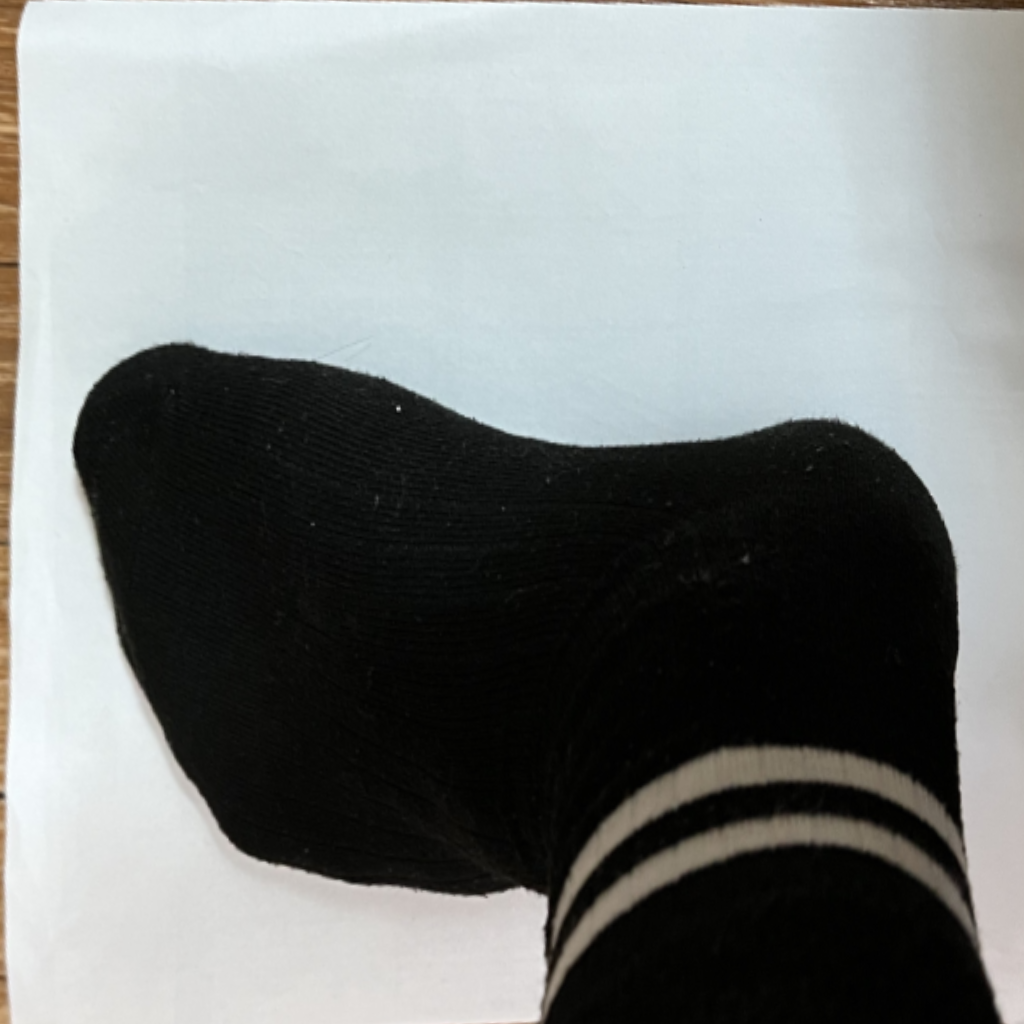

In [ ]:
Conv_Left_Image, Conv_Right_Image = Convert_Image(Ori_Imgae_Left, Ori_Imgae_Right,Ori_Imgae_Left, Ori_Imgae_Right, HomoPara_Left, HomoPara_Right)

In [ ]:
cv2_imshow(Conv_Left_Image)
cv2_imshow(Conv_Right_Image)
MergeImage = cv2.addWeighted(Conv_Left_Image, 0.5 , Conv_Right_Image, 0.5 , 1)

###### 這邊轉換要對準
cv2_imshow(MergeImage)
ResizeImage = cv2.resize(MergeImage, (210, 297), interpolation=cv2.INTER_AREA)

cv2_imshow(ResizeImage)
GrayImage = cv2.cvtColor(ResizeImage, cv2.COLOR_RGB2GRAY)
BlurImage = cv2.GaussianBlur(GrayImage, (15, 15), 0)
_, ThreshImage = cv2.threshold(BlurImage, 20, 255, cv2.THRESH_BINARY)
cv2_imshow(ThreshImage)


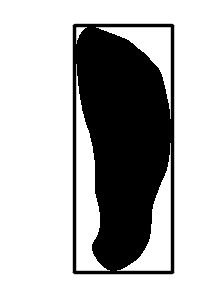

In [ ]:
#boundingbox 框出邊緣 
contours ,hierarchy = cv2.findContours(ThreshImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[1])
BoundBoxImage=cv2.rectangle(ThreshImage,(x,y),(x+w,y+h),(0,0,255),2, cv2.LINE_AA)

cv2_imshow(BoundBoxImage)

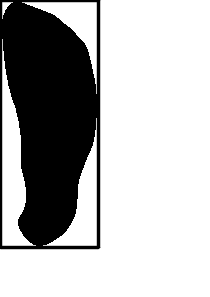

In [ ]:
#平移至原點
M=np.float32([[1,0,-x],[0,1,-y]])
height,width = ThreshImage.shape
result=cv2.warpAffine(ThreshImage,M,(width,height),borderValue=(255,255,255))
cv2_imshow(result)

In [ ]:
ThreshImage.shape

(297, 210)

In [ ]:
#顯示腳長寬
width_text="width: "+str(w)+" mm"
lengh_text="lengh: "+str(h)+" mm"
cv2.putText(result, width_text, (100,250), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)
cv2.putText(result, lengh_text, (100,270), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0, 152, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

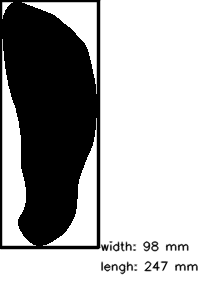

In [ ]:
cv2_imshow(result)

# 裁減原圖方便後續進行填補作業

In [ ]:
def CropImage(Image_Original, Left_Mask, Right_Mask ):
    return cv2.bitwise_and(Image_Original, cv2.bitwise_not(cv2.bitwise_or(Left_Mask, Right_Mask)))

# 將轉換圖檔進行填補

In [ ]:
import cv2

#img = cv2.imread("rect.png")
img = Ori_Imgae_Left
img = cv2.resize(Ori_Imgae_Left, (img.shape[0] * 5, img.shape[1] * 5))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.bilateralFilter(gray, 9, 75, 75)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

perimeter = cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

for point in approx:
    x, y = point[0]
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
cv2.drawContours(img, [approx], -1, (0, 255, 0))

cv2_imshow(img)